# Multivariate Weather Forecasting Using LSTM on Andir District in Bandung

Kevin Putra Santoso - Avalon AI - Department of Information Technology<br>
Sepuluh Nopember Institute of Technology

1. Importing Libraries

In [87]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

2. Load Data

In [89]:
df = pd.read_csv('./Surabaya/Dataset/Bandung_Andir.csv')

In [90]:
df

,time,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,pressure_msl,surface_pressure,precipitation,rain,snowfall,...,et0_fao_evapotranspiration,vapor_pressure_deficit,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,soil_temperature_28_to_100cm,soil_temperature_100_to_255cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,soil_moisture_100_to_255cm
0,1264953600,21.0,99,20.8,25.2,1014.7,924.6,0.1,0.1,0.0,...,0.00,0.02,21.7,22.9,23.5,24.0,0.415,0.427,0.433,0.428
1,1264957200,20.9,97,20.4,24.8,1014.2,924.1,0.6,0.6,0.0,...,0.00,0.07,21.6,22.8,23.5,24.0,0.419,0.420,0.432,0.429
2,1264960800,20.6,98,20.3,24.5,1013.7,923.6,0.6,0.6,0.0,...,0.00,0.04,21.5,22.8,23.5,24.0,0.423,0.418,0.432,0.429
3,1264964400,20.8,97,20.4,24.8,1013.2,923.2,0.0,0.0,0.0,...,0.00,0.07,21.5,22.7,23.5,24.0,0.425,0.420,0.431,0.429
4,1264968000,20.8,97,20.3,24.6,1012.9,922.9,0.0,0.0,0.0,...,0.00,0.07,21.4,22.6,23.5,24.0,0.428,0.420,0.431,0.429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115603,1681124400,23.1,90,21.4,27.0,1011.7,922.5,0.0,0.0,0.0,...,0.03,0.28,23.9,24.4,23.8,23.4,0.406,0.389,0.375,0.419
115604,1681128000,22.2,93,21.0,26.2,1012.5,922.9,0.0,0.0,0.0,...,0.00,0.19,23.2,24.3,23.8,23.4,0.404,0.390,0.375,0.419
115605,1681131600,21.7,95,20.8,25.5,1013.4,923.6,0.0,0.0,0.0,...,0.00,0.14,22.8,24.2,23.8,23.4,0.402,0.390,0.375,0.419
115606,1681135200,21.3,95,20.6,25.1,1013.8,923.9,0.0,0.0,0.0,...,0.00,0.11,22.5,24.1,23.8,23.4,0.401,0.390,0.375,0.419


3. Data Preprocessing

In [91]:
import pytz
from datetime import datetime

tz = pytz.timezone('Asia/Singapore')
time_iso = []
for times in df['time']:
    time_iso.append(datetime.fromtimestamp(times, tz).isoformat())

df['time'] = time_iso
df.index = pd.to_datetime(df['time'], format = '%Y-%m-%dT%H:%M:00+08:00')

In [92]:
main_cols = ['temperature_2m', 'relativehumidity_2m',
             'apparent_temperature','precipitation', 
             'rain','cloudcover','shortwave_radiation',
             'direct_radiation', 'diffuse_radiation',
             'direct_normal_irradiance']


main_df = df[main_cols]

In [93]:
main_df['seconds'] = main_df.index.map(pd.Timestamp.timestamp)

In [94]:
day =  60*60*24
year = 365.2425*day

main_df['sin(day)'] = np.sin(main_df['seconds'] * (2*np.pi/day))
main_df['cos(day)'] = np.cos(main_df['seconds'] * (2*np.pi/day))
main_df['sin(year)'] = np.sin(main_df['seconds'] * (2*np.pi/year))
main_df['cos(year)'] = np.cos(main_df['seconds'] * (2*np.pi/year))

main_df.drop(columns='seconds', inplace=True)

In [95]:
main_df

,temperature_2m,relativehumidity_2m,apparent_temperature,precipitation,rain,cloudcover,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,sin(day),cos(day),sin(year),cos(year)
time,,,,,,,,,,,,,,
2010-02-01 00:00:00,21.0,99,25.2,0.1,0.1,100,0.0,0.0,0.0,0.0,-2.129398e-12,1.000000,0.512803,0.858506
2010-02-01 01:00:00,20.9,97,24.8,0.6,0.6,100,0.0,0.0,0.0,0.0,2.588190e-01,0.965926,0.513419,0.858138
2010-02-01 02:00:00,20.6,98,24.5,0.6,0.6,100,0.0,0.0,0.0,0.0,5.000000e-01,0.866025,0.514033,0.857770
2010-02-01 03:00:00,20.8,97,24.8,0.0,0.0,100,0.0,0.0,0.0,0.0,7.071068e-01,0.707107,0.514648,0.857401
2010-02-01 04:00:00,20.8,97,24.6,0.0,0.0,100,0.0,0.0,0.0,0.0,8.660254e-01,0.500000,0.515263,0.857032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-10 19:00:00,23.1,90,27.0,0.0,0.0,63,30.0,5.0,25.0,35.4,-9.659258e-01,0.258819,0.989004,-0.147890
2023-04-10 20:00:00,22.2,93,26.2,0.0,0.0,61,0.0,0.0,0.0,0.0,-8.660254e-01,0.500000,0.988897,-0.148599
2023-04-10 21:00:00,21.7,95,25.5,0.0,0.0,61,0.0,0.0,0.0,0.0,-7.071068e-01,0.707107,0.988791,-0.149308


In [96]:
def df_to_X_y(df, win_size = 7):
    df_as_np = df.to_numpy()
    X, y = [], []

    for i in range(len(df_as_np) - win_size):
        row = [x for x in df_as_np[i:i+win_size]]
        X.append(row)
        label = [df_as_np[i+win_size][0], df_as_np[i+win_size][1],
                 df_as_np[i+win_size][2], df_as_np[i+win_size][3],
                 df_as_np[i+win_size][4], df_as_np[i+win_size][5],
                 df_as_np[i+win_size][6], df_as_np[i+win_size][7],
                 df_as_np[i+win_size][8], df_as_np[i+win_size][9]]
        y.append(label)
    
    return np.array(X), np.array(y)


In [97]:
X, y = df_to_X_y(main_df)

In [98]:
print(X.shape, y.shape)

(115601, 7, 14) (115601, 10)


In [99]:
X_train, y_train = X[:70000], y[:70000]
X_val, y_val = X[70000:80000], y[70000:80000]
X_test, y_test = X[80000:], y[80000:]

In [100]:
means_list = []
stds_list = []

for i in range(10):
  means_list.append(np.mean(X_train[:, :, i]))
  stds_list.append(np.std(X_train[:, :, i]))

def preprocess(X):
  for i in range(10):
    X[:, :, i] = (X[:, :, i] - means_list[i]) / stds_list[i]

def preprocess_output(y):
  for i in range(10):
    y[:, i] = (y[:, i] - means_list[i]) / stds_list[i]

In [101]:
preprocess(X_train)
preprocess(X_val)
preprocess(X_test)
preprocess_output(y_train)
preprocess_output(y_val)
preprocess_output(y_test)

4. Model Preparation and Training

In [102]:
model = Sequential()
model.add(InputLayer((7,14)))
model.add(LSTM(128)) #64
model.add(Dense(16, 'relu'))
model.add(Dense(10, 'linear'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               73216     
                                                                 
 dense_2 (Dense)             (None, 16)                2064      
                                                                 
 dense_3 (Dense)             (None, 10)                170       
                                                                 
Total params: 75,450
Trainable params: 75,450
Non-trainable params: 0
_________________________________________________________________


In [103]:
checkpoint = ModelCheckpoint('model/', save_best_only=True)
model.compile(
    loss=MeanSquaredError(), 
    optimizer=Adam(learning_rate=0.0001), 
    metrics=[RootMeanSquaredError()])

In [104]:
model.fit(X_train, y_train, 
          validation_data = (X_val, y_val), 
          epochs=30, 
          callbacks=[checkpoint])

Epoch 1/30
2179/2188 [============================>.] - ETA: 0s - loss: 0.2670 - root_mean_squared_error: 0.5167

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2188/2188 [==============================] - 14s 6ms/step - loss: 0.2666 - root_mean_squared_error: 0.5163 - val_loss: 0.1469 - val_root_mean_squared_error: 0.3833
Epoch 2/30
2183/2188 [============================>.] - ETA: 0s - loss: 0.1329 - root_mean_squared_error: 0.3646

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2188/2188 [==============================] - 13s 6ms/step - loss: 0.1330 - root_mean_squared_error: 0.3647 - val_loss: 0.1219 - val_root_mean_squared_error: 0.3491
Epoch 3/30
2185/2188 [============================>.] - ETA: 0s - loss: 0.1189 - root_mean_squared_error: 0.3448

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2188/2188 [==============================] - 13s 6ms/step - loss: 0.1189 - root_mean_squared_error: 0.3448 - val_loss: 0.1140 - val_root_mean_squared_error: 0.3376
Epoch 4/30
2185/2188 [============================>.] - ETA: 0s - loss: 0.1136 - root_mean_squared_error: 0.3371

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2188/2188 [==============================] - 13s 6ms/step - loss: 0.1136 - root_mean_squared_error: 0.3371 - val_loss: 0.1108 - val_root_mean_squared_error: 0.3329
Epoch 5/30
2175/2188 [============================>.] - ETA: 0s - loss: 0.1108 - root_mean_squared_error: 0.3329

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2188/2188 [==============================] - 12s 6ms/step - loss: 0.1109 - root_mean_squared_error: 0.3330 - val_loss: 0.1100 - val_root_mean_squared_error: 0.3317
Epoch 6/30
2188/2188 [==============================] - ETA: 0s - loss: 0.1091 - root_mean_squared_error: 0.3303

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2188/2188 [==============================] - 12s 5ms/step - loss: 0.1091 - root_mean_squared_error: 0.3303 - val_loss: 0.1092 - val_root_mean_squared_error: 0.3305
Epoch 7/30
2180/2188 [============================>.] - ETA: 0s - loss: 0.1078 - root_mean_squared_error: 0.3284

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2188/2188 [==============================] - 14s 6ms/step - loss: 0.1078 - root_mean_squared_error: 0.3283 - val_loss: 0.1073 - val_root_mean_squared_error: 0.3275
Epoch 8/30
2187/2188 [============================>.] - ETA: 0s - loss: 0.1069 - root_mean_squared_error: 0.3270

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2188/2188 [==============================] - 11s 5ms/step - loss: 0.1069 - root_mean_squared_error: 0.3270 - val_loss: 0.1068 - val_root_mean_squared_error: 0.3268
Epoch 9/30
2178/2188 [============================>.] - ETA: 0s - loss: 0.1062 - root_mean_squared_error: 0.3258

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2188/2188 [==============================] - 11s 5ms/step - loss: 0.1060 - root_mean_squared_error: 0.3256 - val_loss: 0.1059 - val_root_mean_squared_error: 0.3255
Epoch 10/30
2184/2188 [============================>.] - ETA: 0s - loss: 0.1054 - root_mean_squared_error: 0.3246

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2188/2188 [==============================] - 11s 5ms/step - loss: 0.1055 - root_mean_squared_error: 0.3247 - val_loss: 0.1054 - val_root_mean_squared_error: 0.3247
Epoch 11/30
2188/2188 [==============================] - 10s 5ms/step - loss: 0.1047 - root_mean_squared_error: 0.3236 - val_loss: 0.1054 - val_root_mean_squared_error: 0.3247
Epoch 12/30
2182/2188 [============================>.] - ETA: 0s - loss: 0.1043 - root_mean_squared_error: 0.3229

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2188/2188 [==============================] - 12s 5ms/step - loss: 0.1042 - root_mean_squared_error: 0.3228 - val_loss: 0.1051 - val_root_mean_squared_error: 0.3243
Epoch 13/30
2182/2188 [============================>.] - ETA: 0s - loss: 0.1037 - root_mean_squared_error: 0.3220

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2188/2188 [==============================] - 13s 6ms/step - loss: 0.1037 - root_mean_squared_error: 0.3220 - val_loss: 0.1051 - val_root_mean_squared_error: 0.3242
Epoch 14/30
2184/2188 [============================>.] - ETA: 0s - loss: 0.1033 - root_mean_squared_error: 0.3214

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2188/2188 [==============================] - 12s 6ms/step - loss: 0.1033 - root_mean_squared_error: 0.3214 - val_loss: 0.1040 - val_root_mean_squared_error: 0.3225
Epoch 15/30
2188/2188 [==============================] - 10s 5ms/step - loss: 0.1030 - root_mean_squared_error: 0.3209 - val_loss: 0.1055 - val_root_mean_squared_error: 0.3248
Epoch 16/30
2182/2188 [============================>.] - ETA: 0s - loss: 0.1025 - root_mean_squared_error: 0.3201

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2188/2188 [==============================] - 13s 6ms/step - loss: 0.1024 - root_mean_squared_error: 0.3200 - val_loss: 0.1036 - val_root_mean_squared_error: 0.3218
Epoch 17/30
2187/2188 [============================>.] - ETA: 0s - loss: 0.1022 - root_mean_squared_error: 0.3198

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2188/2188 [==============================] - 12s 5ms/step - loss: 0.1022 - root_mean_squared_error: 0.3197 - val_loss: 0.1032 - val_root_mean_squared_error: 0.3212
Epoch 18/30
2180/2188 [============================>.] - ETA: 0s - loss: 0.1019 - root_mean_squared_error: 0.3192

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2188/2188 [==============================] - 13s 6ms/step - loss: 0.1019 - root_mean_squared_error: 0.3192 - val_loss: 0.1028 - val_root_mean_squared_error: 0.3206
Epoch 19/30
2188/2188 [==============================] - 10s 5ms/step - loss: 0.1015 - root_mean_squared_error: 0.3186 - val_loss: 0.1040 - val_root_mean_squared_error: 0.3225
Epoch 20/30
2188/2188 [==============================] - 9s 4ms/step - loss: 0.1012 - root_mean_squared_error: 0.3182 - val_loss: 0.1028 - val_root_mean_squared_error: 0.3207
Epoch 21/30
2183/2188 [============================>.] - ETA: 0s - loss: 0.1010 - root_mean_squared_error: 0.3179

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2188/2188 [==============================] - 12s 5ms/step - loss: 0.1010 - root_mean_squared_error: 0.3178 - val_loss: 0.1023 - val_root_mean_squared_error: 0.3198
Epoch 22/30
2188/2188 [==============================] - 23s 10ms/step - loss: 0.1008 - root_mean_squared_error: 0.3174 - val_loss: 0.1029 - val_root_mean_squared_error: 0.3208
Epoch 23/30
2188/2188 [==============================] - 21s 10ms/step - loss: 0.1006 - root_mean_squared_error: 0.3172 - val_loss: 0.1023 - val_root_mean_squared_error: 0.3199
Epoch 24/30
2188/2188 [==============================] - 21s 9ms/step - loss: 0.1003 - root_mean_squared_error: 0.3167 - val_loss: 0.1025 - val_root_mean_squared_error: 0.3202
Epoch 25/30
2185/2188 [============================>.] - ETA: 0s - loss: 0.1001 - root_mean_squared_error: 0.3165

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2188/2188 [==============================] - 27s 12ms/step - loss: 0.1001 - root_mean_squared_error: 0.3164 - val_loss: 0.1021 - val_root_mean_squared_error: 0.3196
Epoch 26/30
2188/2188 [==============================] - 25s 11ms/step - loss: 0.0998 - root_mean_squared_error: 0.3159 - val_loss: 0.1029 - val_root_mean_squared_error: 0.3209
Epoch 27/30
2188/2188 [==============================] - 23s 10ms/step - loss: 0.0997 - root_mean_squared_error: 0.3158 - val_loss: 0.1037 - val_root_mean_squared_error: 0.3220
Epoch 28/30
2184/2188 [============================>.] - ETA: 0s - loss: 0.0995 - root_mean_squared_error: 0.3154

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2188/2188 [==============================] - 27s 12ms/step - loss: 0.0995 - root_mean_squared_error: 0.3154 - val_loss: 0.1017 - val_root_mean_squared_error: 0.3189
Epoch 29/30
2188/2188 [==============================] - 22s 10ms/step - loss: 0.0992 - root_mean_squared_error: 0.3150 - val_loss: 0.1021 - val_root_mean_squared_error: 0.3196
Epoch 30/30
2187/2188 [============================>.] - ETA: 0s - loss: 0.0990 - root_mean_squared_error: 0.3147

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2188/2188 [==============================] - 16s 7ms/step - loss: 0.0990 - root_mean_squared_error: 0.3147 - val_loss: 0.1010 - val_root_mean_squared_error: 0.3179


5. Preparing Time Range Palette For Forecasting

In [115]:
start_date = "2023-04-11 00:00:00"
end_date = "2025-04-10 23:00:00"
time = pd.date_range(start_date, end_date, freq="H")
palette = pd.DataFrame(time, columns=['time'])

In [116]:
palette.index = pd.to_datetime(palette['time'], format='%Y-%m-%d %H:%M:%S')
palette['seconds'] = palette.index.map(pd.Timestamp.timestamp)

In [117]:
palette.drop(columns='time', inplace=True)

palette['sin(day)'] = np.sin(palette['seconds'] * (2*np.pi/day))
palette['cos(day)'] = np.cos(palette['seconds'] * (2*np.pi/day))
palette['sin(year)'] = np.sin(palette['seconds'] * (2*np.pi/year))
palette['cos(year)'] = np.cos(palette['seconds'] * (2*np.pi/year))
palette.drop(columns='seconds', inplace=True)

6. Construct Function for Long Term Forecasting

In [118]:
X_test[-1:]

array([[[ 4.81371207e-01, -4.57644500e-01,  8.03387279e-02,
         -1.36134393e-01, -1.36134393e-01,  2.98735629e-02,
          5.61248055e-01, -3.89938956e-02,  1.79928990e+00,
          5.08425091e-01, -8.66025404e-01, -5.00000000e-01,
          9.89319484e-01, -1.45763362e-01],
        [ 5.65782855e-01, -5.35894803e-01,  2.31961810e-01,
         -3.20677440e-01, -3.20677440e-01, -3.86664200e-01,
          2.98581667e-01, -2.91840016e-01,  1.58007175e+00,
         -1.68432226e-01, -9.65925826e-01, -2.58819045e-01,
          9.89214750e-01, -1.46472451e-01],
        [ 4.39165383e-01, -3.01143895e-01,  2.31961810e-01,
         -4.12948963e-01, -4.12948963e-01, -4.62398339e-01,
         -2.23152941e-01, -5.20832729e-01,  5.16863719e-01,
         -3.35797750e-01, -1.00000000e+00, -8.80881843e-13,
          9.89109507e-01, -1.47181465e-01],
        [ 5.93129645e-02,  3.24858527e-01,  1.94056040e-01,
         -4.12948963e-01, -4.12948963e-01, -4.62398339e-01,
         -6.11755270e-01, -5

In [119]:
model.predict(X_test[-1:])

1/1 [==============================] - 0s 23ms/step


array([[-0.8034252 ,  0.79597163, -0.66634536, -0.3964068 , -0.38875335,
         0.82071835, -0.740507  , -0.6261079 , -0.75575554, -0.67250216]],
      dtype=float32)

In [120]:
def construct_lt_prediction(X, model, palette):
    preds = []
    for i in range(500):
        latest_pred = model.predict(X[-1:], verbose=0)
        last_data = X[-1].tolist()
        new_palette = [last_data[1:] + [[latest_pred[0][0], latest_pred[0][1], latest_pred[0][2], latest_pred[0][3], latest_pred[0][4], latest_pred[0][5], latest_pred[0][6], latest_pred[0][7], latest_pred[0][8], latest_pred[0][9], palette[palette.columns[0]][i], palette[palette.columns[1]][i], palette[palette.columns[2]][i], palette[palette.columns[3]][i]]]]
        X = np.array(X.tolist() + new_palette)
        preds.append(latest_pred)
    
    return X, preds


In [121]:
X_pred_new, predictions = construct_lt_prediction(X_test, model, palette)

In [122]:
prediction_arr = []

for i in range(len(predictions)):
    prediction_arr.append(predictions[i][0].tolist())

In [123]:
forecast_df = pd.DataFrame(prediction_arr, columns=main_df.columns[:-4])

In [124]:
forecast_df['time'] = palette.reset_index()['time'][0:300]

In [125]:
forecast_df

,temperature_2m,relativehumidity_2m,apparent_temperature,precipitation,rain,cloudcover,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,time
0,-0.803425,0.795972,-0.666345,-0.396407,-0.388753,0.820718,-0.740507,-0.626108,-0.755756,-0.672502,2023-04-11 00:00:00
1,-0.882778,0.830454,-0.762908,-0.389291,-0.377166,0.704883,-0.735954,-0.616394,-0.756850,-0.670632,2023-04-11 01:00:00
2,-0.944711,0.840933,-0.839025,-0.364623,-0.367497,0.644885,-0.733365,-0.608678,-0.756382,-0.683918,2023-04-11 02:00:00
3,-0.992718,0.846576,-0.899997,-0.334563,-0.343670,0.609726,-0.729468,-0.606225,-0.754814,-0.692637,2023-04-11 03:00:00
4,-1.031383,0.848468,-0.954995,-0.311147,-0.320597,0.564672,-0.730712,-0.612576,-0.755677,-0.693045,2023-04-11 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...
495,0.559819,0.195328,0.757491,2.470705,2.461591,0.779609,0.430946,-0.228143,1.657341,-0.165025,NaT
496,0.415905,0.244838,0.635704,1.930347,1.916072,0.797796,0.063853,-0.432320,1.037824,-0.372018,NaT
497,0.265881,0.345394,0.520289,1.155203,1.136373,0.762533,-0.230413,-0.515289,0.383717,-0.448170,NaT
498,0.093350,0.539007,0.399200,0.546054,0.520246,0.662894,-0.484503,-0.572002,-0.234138,-0.540513,NaT


In [126]:
forecast_df = forecast_df.reset_index(drop=True)

In [127]:
forecast_df

,temperature_2m,relativehumidity_2m,apparent_temperature,precipitation,rain,cloudcover,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,time
0,-0.803425,0.795972,-0.666345,-0.396407,-0.388753,0.820718,-0.740507,-0.626108,-0.755756,-0.672502,2023-04-11 00:00:00
1,-0.882778,0.830454,-0.762908,-0.389291,-0.377166,0.704883,-0.735954,-0.616394,-0.756850,-0.670632,2023-04-11 01:00:00
2,-0.944711,0.840933,-0.839025,-0.364623,-0.367497,0.644885,-0.733365,-0.608678,-0.756382,-0.683918,2023-04-11 02:00:00
3,-0.992718,0.846576,-0.899997,-0.334563,-0.343670,0.609726,-0.729468,-0.606225,-0.754814,-0.692637,2023-04-11 03:00:00
4,-1.031383,0.848468,-0.954995,-0.311147,-0.320597,0.564672,-0.730712,-0.612576,-0.755677,-0.693045,2023-04-11 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...
495,0.559819,0.195328,0.757491,2.470705,2.461591,0.779609,0.430946,-0.228143,1.657341,-0.165025,NaT
496,0.415905,0.244838,0.635704,1.930347,1.916072,0.797796,0.063853,-0.432320,1.037824,-0.372018,NaT
497,0.265881,0.345394,0.520289,1.155203,1.136373,0.762533,-0.230413,-0.515289,0.383717,-0.448170,NaT
498,0.093350,0.539007,0.399200,0.546054,0.520246,0.662894,-0.484503,-0.572002,-0.234138,-0.540513,NaT


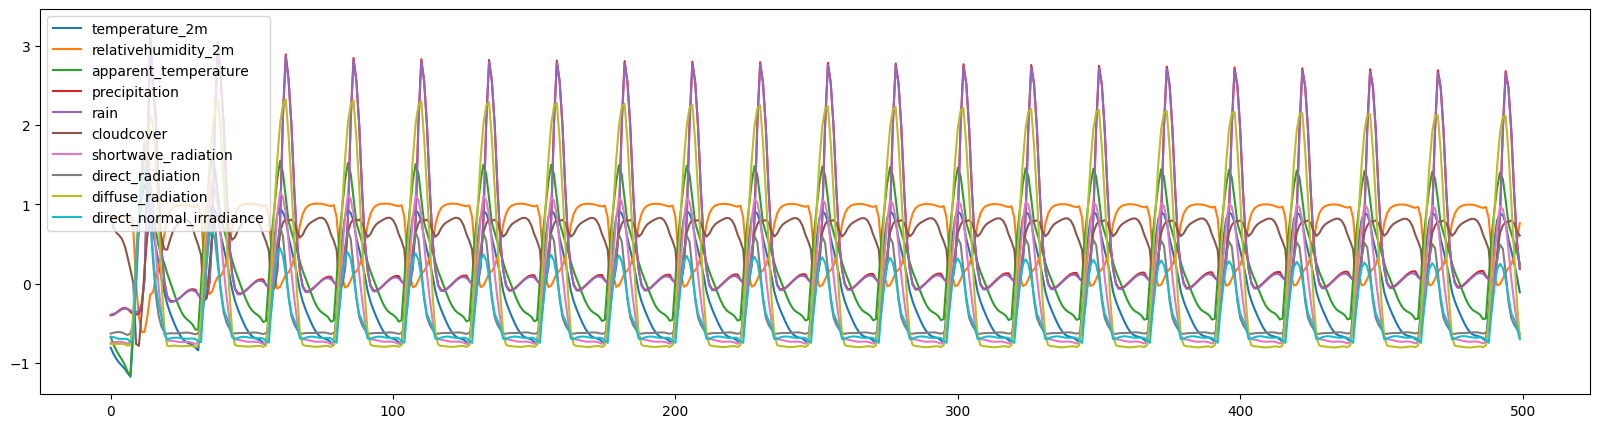

In [128]:
plt.figure(figsize=(20, 5))
plt.plot(forecast_df[forecast_df.columns[:-1]])
plt.legend(forecast_df.columns)